In [23]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import functional as F
import numpy as np
from pycocotools.coco import COCO
import numpy as np
from typing import List, Dict, Tuple, Sequence, Any
from collections import Counter, defaultdict, OrderedDict
from itertools import chain
import random
random.seed(1234)
from dataset import Language, NMTDataset

import torch
import random
from PIL import Image
import torchvision.transforms as transforms
import time
import math

In [24]:
dataDir='../coco'
train_dataType='train2017'
annFile='{}/annotations/captions_{}.json'.format(dataDir,train_dataType)
train_coco=COCO(annFile)

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [25]:
dataDir='../coco'
val_dataType='val2017'
annFile='{}/annotations/captions_{}.json'.format(dataDir,val_dataType)
val_coco=COCO(annFile)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [26]:
train_imgIds = train_coco.getImgIds()[:1000]
train_annIds = train_coco.getAnnIds(imgIds=train_imgIds)
train_anns = train_coco.loadAnns(train_annIds)
batch_size = 64
max_pad_len = 5

In [27]:
val_imgIds = val_coco.getImgIds()[:100]
val_annIds = val_coco.getAnnIds(imgIds=val_imgIds)
val_anns = val_coco.loadAnns(val_annIds)

In [28]:
val_anns[0]['caption']

'A man is in a kitchen making pizzas.'

In [29]:
train_imgIds[:10]

[391895, 522418, 184613, 318219, 554625, 574769, 60623, 309022, 5802, 222564]

In [30]:
img = train_coco.loadImgs(train_anns[1]['image_id'])[0]

In [31]:
img

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

In [32]:
vocab = Language(train_anns)
vocab.build_vocab()

train_dataset = NMTDataset(train_anns, vocab, train_coco, dataDir, train_dataType)
val_dataset = NMTDataset(val_anns, vocab, val_coco, dataDir, val_dataType)

In [33]:
vocab_size = len(vocab.word2idx)
vocab_size

3999

In [42]:
def bucketed_batch_indices(
    sentence_length: List[int],
    batch_size: int,
    max_pad_len: int
) -> List[List[int]]:

    batch_map = defaultdict(list)
    batch_indices_list = []

    tgt_len_min = min(sentence_length)

    for idx, tgt_len in enumerate(sentence_length):
        tgt = (tgt_len - tgt_len_min + 1) // (5)
        batch_map[tgt].append(idx)

    for key, value in batch_map.items():
        batch_indices_list += [value[i: i+batch_size] for i in range(0, len(value), batch_size)]

    random.shuffle(batch_indices_list)
    batch_indices_list = [x for x in batch_indices_list if len(x)==batch_size]

    return batch_indices_list

def collate_fn(
    batched_samples: List[Tuple[torch.Tensor, torch.Tensor]]
) -> Tuple[torch.Tensor, torch.Tensor]:

    batched_samples = sorted(batched_samples, key=lambda sample: len(sample[1]), reverse=True)
    # import pdb;pdb.set_trace()
    src_images = list(map(lambda sample: sample[0], batched_samples))
    src_images = torch.stack(src_images)
    tgt_sentences = []
    for sample in batched_samples:
        tgt_sentences.append(sample[1])

    tgt_sentences = torch.nn.utils.rnn.pad_sequence(tgt_sentences, batch_first=True)

    return src_images, tgt_sentences

In [43]:
train_sentence_length = list(map(lambda x: len(x[1]), train_dataset))


In [44]:
val_sentence_length = list(map(lambda x: len(x[1]), val_dataset))

In [45]:
len(train_sentence_length)

5004

In [46]:
train_indices = bucketed_batch_indices(train_sentence_length, batch_size=batch_size, max_pad_len=max_pad_len)
val_indices = bucketed_batch_indices(val_sentence_length, batch_size=batch_size, max_pad_len=max_pad_len)

In [47]:
for x in val_indices:
    if len(x) != 64:
        print(len(x))

In [48]:
for x in train_indices:
    if len(x) != 64:
        print(len(x))

In [41]:
train_dataloader = torch.utils.data.dataloader.DataLoader(train_dataset, collate_fn=collate_fn, num_workers=2, batch_sampler=bucketed_batch_indices(train_sentence_length, batch_size=batch_size, max_pad_len=max_pad_len))
val_dataloader = torch.utils.data.dataloader.DataLoader(val_dataset, collate_fn=collate_fn, num_workers=2, batch_sampler=bucketed_batch_indices(val_sentence_length, batch_size=batch_size, max_pad_len=max_pad_len))

tensor([   2,  179, 1891,   40,  103,   10,  207,   22,   19, 2268, 1027,    3])


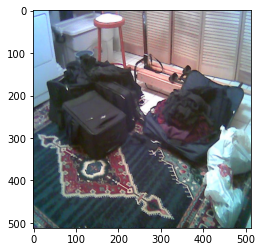

In [49]:
s = next(iter(train_dataloader))

import torch
import matplotlib.pyplot as plt

axs = plt.imshow(s[0][0].permute(1,2,0).numpy())
print(s[1][0])



In [50]:
sentence = [vocab.idx2word[x] for x in s[1][0]]

In [51]:
sentence

['<SOS>',
 'The',
 'luggage',
 'is',
 'sitting',
 'on',
 'top',
 'of',
 'the',
 'persian',
 'rug',
 '<EOS>']

In [52]:
len(val_dataloader)


11

In [53]:
embedding_size = 512
hidden_size = 512
num_layers = 2
num_dirs = 2
dropout = 0.1

In [54]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.backbone = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1])
        
        self.embedding = nn.Linear(in_features= 512, out_features = embedding_size, bias=True)        

    
    def forward(self, img):
        output = self.backbone(img)
        output = torch.flatten(output, start_dim=1)
        output = self.embedding(output)

        return output

In [55]:
encoder = Encoder()

In [56]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(
            embedding_size,
            hidden_size,
            num_layers=2,
            bidirectional=True
        )
        self.output_linear = nn.Linear(2*hidden_size, vocab_size)

    def forward(self, batch, hidden):
        batch_emb = self.embedding(batch)
        
        batch_emb = batch_emb.unsqueeze(0)

        outputs, hidden = self.rnn(batch_emb, hidden)

        return self.output_linear(outputs).squeeze(0), hidden

In [57]:
decoder = Decoder()

In [58]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src_batch, trg_batch, teacher_forcing_prob=1.0):
        img_embedding = self.encoder(src_batch).unsqueeze(0)
        # import pdb;pdb.set_trace()
        input_ids = trg_batch[:,0]
        batch_size = src_batch.shape[0]
        trg_max_len = len(trg_batch[0])
        outputs = torch.zeros(trg_max_len, batch_size, vocab_size).to(device)
        _, hidden = self.decoder.rnn(img_embedding)

        for t in range(1, trg_max_len):
            decoder_outputs, hidden = self.decoder(input_ids, hidden)

            outputs[t] = decoder_outputs
            _, top_ids = torch.max(decoder_outputs, dim=-1)

            input_ids = trg_batch[:,t] if random.random() > teacher_forcing_prob else top_ids
            
        return outputs


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.device_count() > 1:
    print("using multiple GPU")
    seq2seq = nn.DataParallel(seq2seq)
seq2seq = seq2seq.to(device)

using multiple GPU


In [61]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, seq2seq.parameters()),
                                             lr=0.001)

In [62]:
def train():
    seq2seq.train()
    total_loss=0.
    for idx, (imgs, trgs) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        imgs, trgs = imgs.to(device), trgs.to(device)
        output = seq2seq(imgs,trgs)

        loss = criterion(output.view(-1,vocab_size), trgs.flatten())
        loss.backward()
        total_loss+=loss.item()
        optimizer.step()
    return total_loss / len(train_dataloader)

In [63]:
def val():
    seq2seq.eval()
    total_loss=0.
    with torch.no_grad():
        for idx, (imgs, trgs) in tqdm(enumerate(val_dataloader)):
            imgs, trgs = imgs.to(device), trgs.to(device)
            output = seq2seq(imgs, trgs)
            total_loss+= criterion(output.view(-1, vocab_size), trgs.flatten()).item()
    return total_loss / len(val_dataloader)


In [64]:
try:
    for epoch in range(6):
        epoch_start_time = time.time()
        train_loss = train()
        print(train_loss)
        val_loss = val()
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

0it [00:00, ?it/s]/data/jhpark/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
35it [00:50,  1.43s/it]

-----------------------------------------------------------------------------------------
Exiting from training early
